In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
import json
from model import NN
from functions import  *

In [14]:

class Environment:
    def __init__(self, seed, parameters, NN):
        # setting parameters
        self.DAYS = parameters['params']['DAYS']
        self.TRIALS = parameters['params']['TRIALS']
        self.N_SYLL = parameters['params']['N_SYLL']
        self.hvc_size = parameters['const']['HVC_SIZE']
        self.bg_size = parameters['const']['BG_SIZE']
        self.ra_size = parameters['const']['RA_SIZE']
        self.mc_size = parameters['const']['MC_SIZE']
        self.n_distractors = parameters['params']['N_DISTRACTORS']
        self.target_width = parameters['params']['TARGET_WIDTH']
        self.seed = seed
        # np.random.seed(seed)
        self.model = NN(parameters, seed)
        # landscape parameters
        self.centers = np.random.uniform(-0.9, 0.9, (self.N_SYLL, 2))
        self.heights = np.random.uniform(0.2, 0.7, (self.N_SYLL, self.n_distractors))
        self.means = np.random.uniform(-1, 1, (self.N_SYLL,self.n_distractors, 2))
        self.spreads = np.random.uniform(0.1, 0.6, (self.N_SYLL, self.n_distractors))
        # data storage
        self.rewards = np.zeros((self.DAYS, self.TRIALS, self.N_SYLL))
        self.actions = np.zeros((self.DAYS, self.TRIALS, self.N_SYLL, self.mc_size))
        self.hvc_bg_array = np.zeros((self.DAYS, self.TRIALS, self.N_SYLL))
        self.bg_out = np.zeros((self.DAYS, self.TRIALS, self.N_SYLL))
        self.hvc_ra_array = np.zeros((self.DAYS, self.TRIALS, self.N_SYLL))
        self.ra_out = np.zeros((self.DAYS, self.TRIALS, self.N_SYLL))
        self.dw_day_array = np.zeros((self.DAYS, self.N_SYLL))
        self.pot_array = np.zeros((self.DAYS, self.N_SYLL))
        
    def get_reward(self, coordinates, syll):
        # landscape creation and reward calculation
        center = self.centers[syll, :]
        reward_scape = gaussian(coordinates, 1, center, self.target_width)
        if self.n_distractors == 0:
            return reward_scape
        hills = []
        hills.append(reward_scape)
        for i in range(self.n_distractors):
            height = self.heights[syll, i]
            mean = self.means[syll, i,:]
            spread = self.spreads[syll, i]
            hills.append(gaussian(coordinates, height, mean, spread))
        return np.maximum.reduce(hills)
     
    def run(self, parameters, annealing = False):
        # modes 
        self.annealing = annealing
        self.model.bg_influence = True
        # learning parameters
        self.learning_rate = parameters['params']['LEARNING_RATE_RL']
        learning_rate_hl = parameters['params']['LEARNING_RATE_HL']
        REWARD_WINDOW = parameters['params']['REWARD_WINDOW']
        HEBBIAN_LEARNING = parameters['params']['HEBBIAN_LEARNING']
        ANNEALING_SLOPE = parameters['params']['ANNEALING_SLOPE']
        ANNEALING_MID = parameters['params']['ANNEALING_MID']

        # each day, 1000 trial, n_syll syllables
        for day in tqdm(range(self.DAYS)):
            dw_day = np.zeros(self.N_SYLL)
            self.model.bg_influence = True
            if day >= self.DAYS-1: 
                self.model.bg_influence = False # BG lesion on the last day
            for iter in range(self.TRIALS):
                for syll in range(self.N_SYLL):
                    # input from HVC is determined by the syllable
                    input_hvc = np.zeros(self.hvc_size)
                    input_hvc[syll] = 1
                    # reward, action and baseline
                    action, ra, bg = self.model.forward(input_hvc, parameters)
                    reward = self.get_reward(action, syll)
                    self.rewards[day, iter, syll] = reward
                    self.actions[day, iter, syll,:] = action
                    reward_baseline = 0
                    if iter < REWARD_WINDOW and iter > 0:
                        reward_baseline = np.mean(self.rewards[day, :iter, syll])
                    elif iter >= REWARD_WINDOW:
                        reward_baseline = np.mean(self.rewards[day, iter-REWARD_WINDOW:iter, syll])
                    # Updating weights
                    # RL update
                    dw_hvc_bg = self.learning_rate*(reward - reward_baseline)*input_hvc.reshape(self.hvc_size,1)*self.model.bg * self.model.bg_influence # RL update
                    self.model.W_hvc_bg += dw_hvc_bg
                    # HL update
                    dw_hvc_ra = learning_rate_hl*input_hvc.reshape(self.hvc_size,1)*self.model.ra*HEBBIAN_LEARNING # lr is supposed to be much smaller here
                    self.model.W_hvc_ra += dw_hvc_ra
                    # bound weights between +-1
                    # np.clip(self.model.W_hvc_bg, -1, 1, out = self.model.W_hvc_bg)
                    # np.clip(self.model.W_hvc_ra, -1, 1, out = self.model.W_hvc_ra)
                    np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_bg, 1, out = self.model.W_hvc_bg), -1, out = self.model.W_hvc_bg) # type: ignore
                    np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_ra, 1, out = self.model.W_hvc_ra), -1, out = self.model.W_hvc_ra) # type: ignore
                    # storing values for plotting
                    dw_day[syll] += np.mean(np.abs(dw_hvc_bg))
                    self.hvc_bg_array[day, iter, syll] = self.model.W_hvc_bg[syll,1]
                    self.bg_out[day, iter, syll] = bg[1]
                    self.hvc_ra_array[day, iter, syll] = self.model.W_hvc_ra[syll,1]
                    self.ra_out[day, iter, syll] = ra[0]
            # Annealing
            if self.annealing:
                for syll in range(self.N_SYLL):
                    ''' input daily sum, output scaling factor for potentiation'''
                    # calculating potentiation 
                    d = dw_day[syll]*100 # scaling up to be comparable
                    p = 1 * sigmoid(1*d, m = ANNEALING_SLOPE, a = ANNEALING_MID)
                    potentiation_factor = np.zeros((self.hvc_size))
                    potentiation_factor[syll] = 1-p 
                    # implementing night weight changes
                    night_noise = np.random.uniform(-1, 1, self.bg_size) # make it lognormal
                    dw_night = self.learning_rate*potentiation_factor.reshape(self.hvc_size,1)*night_noise*10*self.model.bg_influence
                    self.model.W_hvc_bg += dw_night
                    self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
                    # storing values
                    self.pot_array[day, syll] = 1-p
                    self.dw_day_array[day, syll] = d
        
    def save_trajectory(self, syll):
        fig, axs = plt.subplots(figsize=(10, 9))
        # generate grid 
        limit = 1.5
        x, y = np.linspace(-limit,limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y], syll)
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'black'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
        axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.2, linewidth = 0, marker='.') # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=100, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=50, c='green', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title(f'Contour plot of reward function SEED:{self.seed} syllable: {syll}')
        axs.set_ylabel(r'$P_{\alpha}$')
        axs.set_xlabel(r'$P_{\beta}$')
        axs.legend()
        plt.tight_layout()
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"trajectory_{self.seed}_{syll}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_results(self, syll):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards[:,:,syll].reshape(self.DAYS*self.TRIALS), '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, self.DAYS*self.TRIALS, colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(self.DAYS*self.TRIALS))
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out[:,:,syll].reshape(self.DAYS*self.TRIALS),'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(self.DAYS*self.TRIALS))
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions[:,:,syll,0].reshape(self.DAYS*self.TRIALS))
        axs[4].plot(self.actions[:,:,syll,1].reshape(self.DAYS*self.TRIALS))
        axs[4].plot(self.centers[syll, 0]*np.ones(self.TRIALS*self.DAYS))
        axs[4].plot(self.centers[syll, 1]*np.ones(self.TRIALS*self.DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out[:,:,syll].reshape(self.DAYS*self.TRIALS))
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        axs[5].set_xlabel('Days')
        for i in range(1,6):
            axs[i].set_xticks(range(0, self.DAYS*self.TRIALS, 10*self.TRIALS), range(0, self.DAYS, 10))
        fig.suptitle(f'Results SEED:{self.seed} syllable: {syll}', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"results_{self.seed}_{syll}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_dw_day(self, syll):
        if self.annealing:
            expanded_dw_day_array = np.zeros((self.DAYS*self.TRIALS, self.N_SYLL))
            expanded_pot_array = np.zeros((self.DAYS*self.TRIALS, self.N_SYLL))
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], self.DAYS*self.TRIALS// len(self.dw_day_array[:, syll]))
            expanded_pot_array = np.repeat(self.pot_array[:, syll], self.DAYS*self.TRIALS// len(self.pot_array[:, syll]))
            plt.title(f'Annealing SEED:{self.seed} syllable: {syll}')
            plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            plt.plot(self.rewards[:,:,syll].reshape(self.DAYS*self.TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
            plt.xlabel('Days')
            plt.ylabel('dW_day')
            plt.legend()
            # Create the "plots" directory if it doesn't exist
            os.makedirs(save_dir, exist_ok = True)
            # Save the plot
            plt.savefig(os.path.join(save_dir, f"dw_{self.seed}_{syll}.png"))
            plt.close()  # Close the plot to avoid memory leaks  

    def plot_combined_returns(self):
        plt.figure()
        for i in range(self.N_SYLL):
            plt.plot(self.rewards[:,:,i].reshape(self.DAYS*self.TRIALS), '.', markersize=0.3, color='pink')
            lined = np.convolve(self.rewards[:,:,i].reshape(self.DAYS*self.TRIALS), np.ones((100,))/100, mode='same')
            plt.plot(lined, color='violet')
        plt.plot(np.convolve(self.rewards.mean(axis = 2).reshape(self.DAYS*self.TRIALS),np.ones((100,))/100, mode='same'), color='black', label='Mean')
        plt.xlabel('Days')
        plt.xticks(range(0, self.DAYS*self.TRIALS, 10*self.TRIALS), range(0, self.DAYS, 10))
        plt.ylabel('Performance Metric')
        plt.legend()
        plt.show()

    def plot_trajectory(self, syll):
        fig, axs = plt.subplots(figsize=(10, 9))
        # generate grid 
        limit = 1.5
        x, y = np.linspace(-limit,limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y], syll)
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'black'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
        axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.7, linewidth = 0.5) # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=100, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=50, c='green', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title(f'Contour plot of reward function SEED:{self.seed} syllable: {syll}')
        axs.set_ylabel(r'$P_{\alpha}$')
        axs.set_xlabel(r'$P_{\beta}$')
        axs.legend()
        plt.tight_layout()
        plt.show()
        # # Create the "plots" directory if it doesn't exist
        # os.makedirs(save_dir, exist_ok = True)
        # # Save the plot
        # plt.savefig(os.path.join(save_dir, f"trajectory_{self.seed}_{syll}.png"))
        # plt.close()  # Close the plot to avoid memory leaks
    
    def plot_results(self, syll):   
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards[:,:,syll].reshape(self.DAYS*self.TRIALS), '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, self.DAYS*self.TRIALS, colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(self.DAYS*self.TRIALS))
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out[:,:,syll].reshape(self.DAYS*self.TRIALS),'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(self.DAYS*self.TRIALS))
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions[:,:,syll,0].reshape(self.DAYS*self.TRIALS))
        axs[4].plot(self.actions[:,:,syll,1].reshape(self.DAYS*self.TRIALS))
        axs[4].plot(self.centers[syll, 0]*np.ones(self.TRIALS*self.DAYS))
        axs[4].plot(self.centers[syll, 1]*np.ones(self.TRIALS*self.DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1.5, 1.5)
        axs[5].plot(self.ra_out[:,:,syll].reshape(self.DAYS*self.TRIALS))
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        axs[5].set_xlabel('Days')
        for i in range(0,6):
            axs[i].set_xticks(range(0, self.DAYS*self.TRIALS, 10*self.TRIALS), range(0, self.DAYS, 10))
        fig.suptitle(f'Results SEED:{self.seed} syllable: {syll}', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # # Create the "plots" directory if it doesn't exist
        # os.makedirs(save_dir, exist_ok = True)
        # # Save the plot
        # plt.savefig(os.path.join(save_dir, f"results_{self.seed}_{syll}.png"))
        # plt.close()  # Close the plot to avoid memory leaks
        plt.show()

def build_and_run(seed, annealing, plot, parameters, NN):
    N_SYLL = parameters['params']['N_SYLL']
    tqdm.write(f" Random seed is {seed}")
    np.random.seed(seed)
    env = Environment(seed, parameters, NN)
    env.run(parameters, annealing)
    for i in range(N_SYLL):
        if plot:
            env.plot_trajectory(i)
            env.plot_results(i)
            # if annealing:
            #     env.save_dw_day(i)
        rewards = env.rewards[:,:,0].reshape(env.DAYS*env.TRIALS)
    env.plot_combined_returns()
    return np.mean(rewards[-100:], axis=0)


In [15]:
# load parameters from json file
params_path = "params.json"
# Open the file and read the contents
seed = 13
annealing = True
plot = True
with open(params_path, "r") as f: 
    parameters = json.load(f)
    N_SYLL = parameters['params']['N_SYLL']
    tqdm.write(f" Random seed is {seed}")
    np.random.seed(seed)
    env = Environment(seed, parameters, NN)
    env.run(parameters, annealing)
    


 Random seed is 13


100%|██████████| 1/1 [00:00<00:00, 428.78it/s]


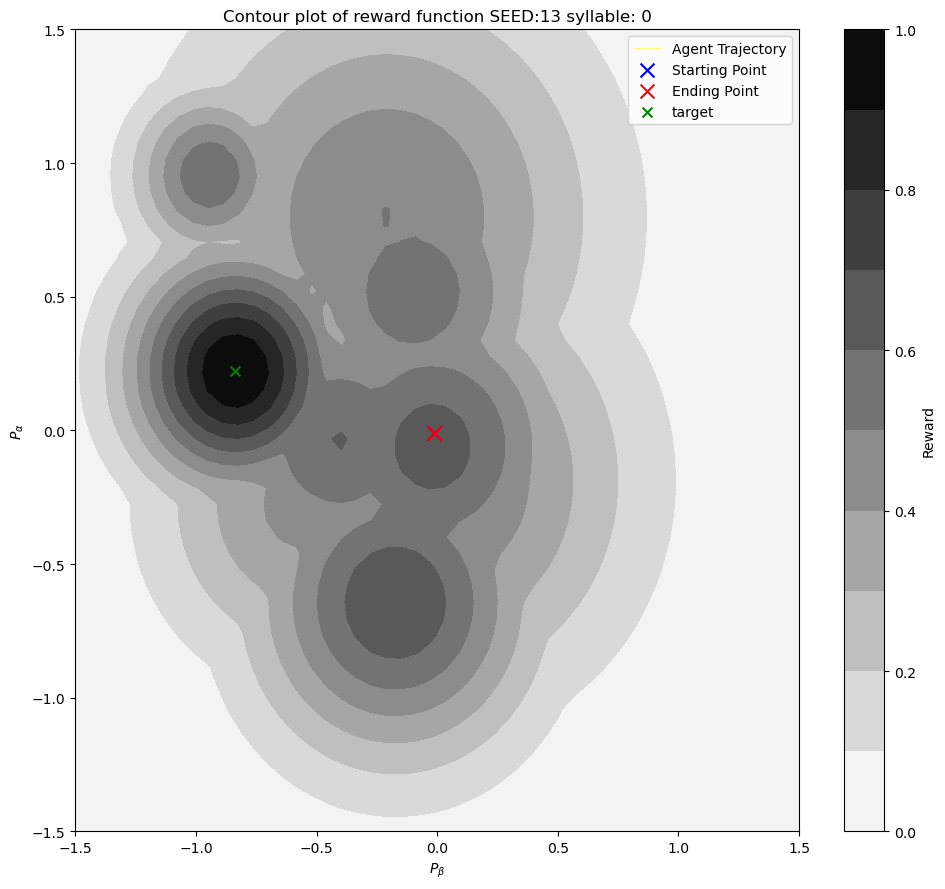

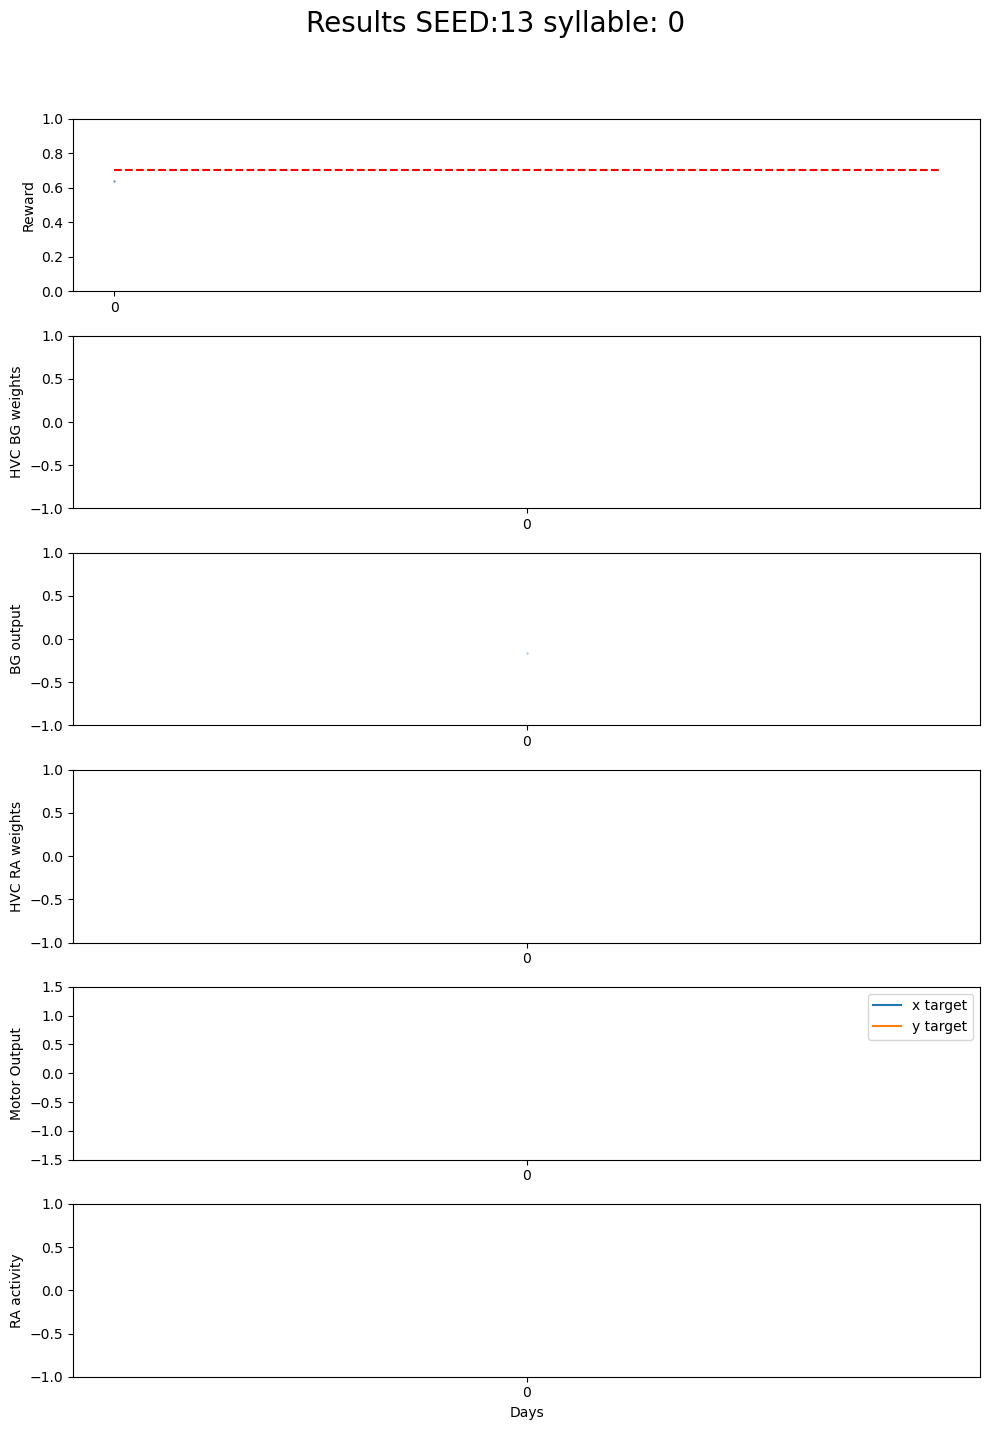

In [16]:
for i in range(N_SYLL):
    if plot:
        env.plot_trajectory(i)
        env.plot_results(i)
        # if annealing:
        #     env.save_dw_day(i)
    rewards = env.rewards[:,:,0].reshape(env.DAYS*env.TRIALS)
# env.plot_combined_returns()

# running conditions
# N_SYLL = parameters['run']['N_SYLL']
ANNEALING = parameters['params']['ANNEALING']

# if N_SYLL > 5 or N_SYLL < 1:
#     ValueError('Invalid number of syllables')
RANDOM_SEED = 13
remove_prev_files()

# build_and_run(RANDOM_SEED, annealing = ANNEALING, plot = True, parameters = parameters1, NN = NN)